In [1]:
# Week 4: Model Optimization and Final Evaluation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import joblib

In [2]:
file_path = r"C:\Users\Faizan\OneDrive - BENNETT UNIVERSITY\blood disease\cardio_train.csv\cleaned_cardio_data.csv"
df = pd.read_csv(file_path)

In [3]:
df['bp_category'] = pd.cut(df['ap_hi'], bins=[0, 120, 130, 140, float('inf')], 
                          labels=['Normal', 'Elevated', 'High Stage 1', 'High Stage 2'], right=False)
df['bp_interaction'] = df['ap_hi'] * df['ap_lo']
df = pd.get_dummies(df, columns=['age_group', 'bp_category'], drop_first=True)
X = df.drop(columns=['id', 'age', 'cardio'])
y = df['cardio']
scaler = StandardScaler()
numerical_cols = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi', 'bp_interaction']
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Recreate Week 2 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Train Random Forest (tuned from Week 3)
rf_model = RandomForestClassifier(max_depth=10, min_samples_split=2, n_estimators=200, random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)
y_test_pred_rf = rf_model.predict(X_test)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)

In [5]:
xgb_model = XGBClassifier(scale_pos_weight=1.0, random_state=42)  
xgb_model.fit(X_train_balanced, y_train_balanced)
y_test_pred_xgb = xgb_model.predict(X_test)
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)

# Display results
print("Random Forest (with SMOTE) - Testing Accuracy:", round(test_accuracy_rf, 4))
print("XGBoost (with SMOTE) - Testing Accuracy:", round(test_accuracy_xgb, 4))
print("\nRandom Forest - Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred_rf))
print("\nXGBoost - Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred_xgb))

Random Forest (with SMOTE) - Testing Accuracy: 0.7334
XGBoost (with SMOTE) - Testing Accuracy: 0.7307

Random Forest - Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.71      0.78      0.75      6471
           1       0.76      0.69      0.72      6430

    accuracy                           0.73     12901
   macro avg       0.74      0.73      0.73     12901
weighted avg       0.74      0.73      0.73     12901


XGBoost - Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.72      0.77      0.74      6471
           1       0.75      0.69      0.72      6430

    accuracy                           0.73     12901
   macro avg       0.73      0.73      0.73     12901
weighted avg       0.73      0.73      0.73     12901



In [6]:
# Load the baseline model from Week 2
baseline_model_path = r"C:\Users\Faizan\OneDrive - BENNETT UNIVERSITY\blood disease\cardio_train.csv\logistic_regression_baseline.pkl"
baseline_model = joblib.load(baseline_model_path)

# Load the tuned Random Forest from Week 3
tuned_rf_model_path = r"C:\Users\Faizan\OneDrive - BENNETT UNIVERSITY\blood disease\cardio_train.csv\tuned_random_forest_model.pkl"
tuned_rf_model = joblib.load(tuned_rf_model_path)

In [7]:
y_test_prob_baseline = baseline_model.predict_proba(X_test)[:, 1]
y_test_prob_tuned_rf = tuned_rf_model.predict_proba(X_test)[:, 1]
y_test_prob_rf = rf_model.predict_proba(X_test)[:, 1]
y_test_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

roc_auc_baseline = roc_auc_score(y_test, y_test_prob_baseline)
roc_auc_tuned_rf = roc_auc_score(y_test, y_test_prob_tuned_rf)
roc_auc_rf = roc_auc_score(y_test, y_test_prob_rf)
roc_auc_xgb = roc_auc_score(y_test, y_test_prob_xgb)

print("ROC-AUC Scores:")
print("Baseline Logistic Regression:", round(roc_auc_baseline, 4))
print("Tuned Random Forest (Week 3):", round(roc_auc_tuned_rf, 4))
print("Random Forest (with SMOTE):", round(roc_auc_rf, 4))
print("XGBoost (with SMOTE):", round(roc_auc_xgb, 4))

ROC-AUC Scores:
Baseline Logistic Regression: 0.7955
Tuned Random Forest (Week 3): 0.8008
Random Forest (with SMOTE): 0.8008
XGBoost (with SMOTE): 0.7944


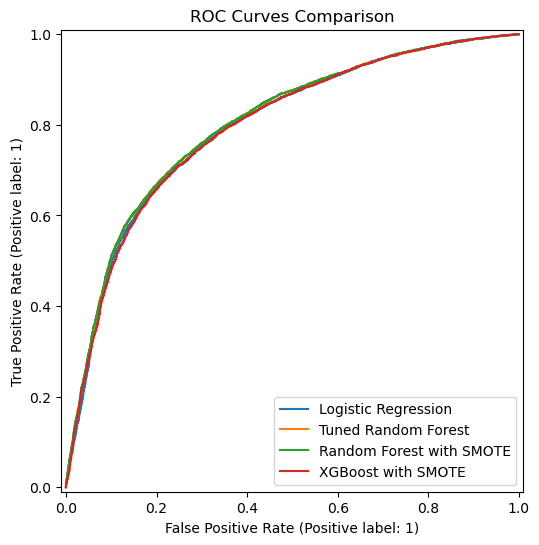

In [8]:
from sklearn.metrics import RocCurveDisplay
plt.figure(figsize=(10, 6))
RocCurveDisplay.from_estimator(baseline_model, X_test, y_test, ax=plt.gca(), label="Logistic Regression")
RocCurveDisplay.from_estimator(tuned_rf_model, X_test, y_test, ax=plt.gca(), label="Tuned Random Forest")
RocCurveDisplay.from_estimator(rf_model, X_test, y_test, ax=plt.gca(), label="Random Forest with SMOTE")
RocCurveDisplay.from_estimator(xgb_model, X_test, y_test, ax=plt.gca(), label="XGBoost with SMOTE")
plt.title("ROC Curves Comparison")
plt.legend()
plt.show()

In [19]:
from sklearn.model_selection import GridSearchCV

# 3. Tuning and Final Model Selection (Balanced Approach)
# Tune XGBoost with F1-score optimization
param_grid = {
    'scale_pos_weight': [1.0, 1.5, 2.0],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
xgb = XGBClassifier(random_state=42, n_estimators=100)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_balanced, y_train_balanced)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'scale_pos_weight': [1.0, 1.5, 2.0]},
             scoring='f1')

In [20]:
best_xgb_model = grid_search.best_estimator_
y_test_prob_best_xgb = best_xgb_model.predict_proba(X_test)[:, 1]
y_test_pred_best_xgb = best_xgb_model.predict(X_test)
test_accuracy_best_xgb = accuracy_score(y_test, y_test_pred_best_xgb)
roc_auc_best_xgb = roc_auc_score(y_test, y_test_prob_best_xgb)

# Test different thresholds for better balance
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
best_threshold = 0.5
best_f1 = 0.0
for thresh in thresholds:
    y_test_pred_thresh = (y_test_prob_best_xgb >= thresh).astype(int)
    f1 = classification_report(y_test, y_test_pred_thresh, output_dict=True)['1']['f1-score']
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh
y_test_pred_best_xgb_adjusted = (y_test_prob_best_xgb >= best_threshold).astype(int)

# Final metrics with adjusted threshold
test_accuracy_best_xgb_adjusted = accuracy_score(y_test, y_test_pred_best_xgb_adjusted)
roc_auc_best_xgb_adjusted = roc_auc_score(y_test, y_test_prob_best_xgb)
recall_best_xgb_adjusted = classification_report(y_test, y_test_pred_best_xgb_adjusted, output_dict=True)['1']['recall']
precision_best_xgb_adjusted = classification_report(y_test, y_test_pred_best_xgb_adjusted, output_dict=True)['1']['precision']

In [21]:
# Evaluate all models with adjusted threshold
models = {
    'Logistic Regression': baseline_model,
    'Tuned Random Forest': tuned_rf_model,
    'Random Forest with SMOTE': rf_model,
    'Tuned XGBoost': best_xgb_model
}
results = {}
for name, model in models.items():
    y_test_prob = model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_prob >= best_threshold).astype(int)
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_test_pred),
        'ROC-AUC': roc_auc_score(y_test, y_test_prob),
        'Recall (Class 1)': classification_report(y_test, y_test_pred, output_dict=True)['1']['recall'],
        'Precision (Class 1)': classification_report(y_test, y_test_pred, output_dict=True)['1']['precision'],
        'F1-Score (Class 1)': classification_report(y_test, y_test_pred, output_dict=True)['1']['f1-score']
    }

In [22]:
# Display results
print("Best XGBoost Parameters:", grid_search.best_params_)
print(f"Optimal Threshold: {best_threshold}")
print("Tuned XGBoost (Adjusted Threshold) - Testing Accuracy:", round(test_accuracy_best_xgb_adjusted, 4))
print("Tuned XGBoost (Adjusted Threshold) - ROC-AUC Score:", round(roc_auc_best_xgb_adjusted, 4))
print("Tuned XGBoost (Adjusted Threshold) - Recall (Class 1):", round(recall_best_xgb_adjusted, 4))
print("Tuned XGBoost (Adjusted Threshold) - Precision (Class 1):", round(precision_best_xgb_adjusted, 4))
print("\nModel Comparison (with Optimal Threshold):")
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  Accuracy: {round(metrics['Accuracy'], 4)}")
    print(f"  ROC-AUC: {round(metrics['ROC-AUC'], 4)}")
    print(f"  Recall (Class 1): {round(metrics['Recall (Class 1)'], 4)}")
    print(f"  Precision (Class 1): {round(metrics['Precision (Class 1)'], 4)}")
    print(f"  F1-Score (Class 1): {round(metrics['F1-Score (Class 1)'], 4)}")

# Save the best model (highest F1-score)
best_model_name = max(results, key=lambda x: results[x]['F1-Score (Class 1)'])
best_model = models[best_model_name]
save_path = f"C:\\Users\\Faizan\\OneDrive - BENNETT UNIVERSITY\\blood disease\\cardio_train.csv\\{best_model_name.replace(' ', '_')}_balanced.pkl"
joblib.dump(best_model, save_path)
print(f"\nBest model saved as: {save_path}")

Best XGBoost Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'scale_pos_weight': 1.5}
Optimal Threshold: 0.5
Tuned XGBoost (Adjusted Threshold) - Testing Accuracy: 0.7234
Tuned XGBoost (Adjusted Threshold) - ROC-AUC Score: 0.802
Tuned XGBoost (Adjusted Threshold) - Recall (Class 1): 0.7846
Tuned XGBoost (Adjusted Threshold) - Precision (Class 1): 0.698

Model Comparison (with Optimal Threshold):
Logistic Regression:
  Accuracy: 0.7293
  ROC-AUC: 0.7955
  Recall (Class 1): 0.6557
  Precision (Class 1): 0.7674
  F1-Score (Class 1): 0.7071
Tuned Random Forest:
  Accuracy: 0.7348
  ROC-AUC: 0.8008
  Recall (Class 1): 0.6843
  Precision (Class 1): 0.7598
  F1-Score (Class 1): 0.7201
Random Forest with SMOTE:
  Accuracy: 0.7334
  ROC-AUC: 0.8008
  Recall (Class 1): 0.6858
  Precision (Class 1): 0.7566
  F1-Score (Class 1): 0.7195
Tuned XGBoost:
  Accuracy: 0.7234
  ROC-AUC: 0.802
  Recall (Class 1): 0.7846
  Precision (Class 1): 0.698
  F1-Score (Class 1): 0.7388

Best model saved as: C:\

In [23]:
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 4. Final Evaluation and Deployment
# Load the best balanced model
best_model_path = "C:\\Users\\Faizan\\OneDrive - BENNETT UNIVERSITY\\blood disease\\cardio_train.csv\\Tuned_XGBoost_balanced.pkl"
best_model = joblib.load(best_model_path)
best_threshold = 0.5  # From Section 3

# Predict probabilities and labels with optimal threshold
y_test_prob_best = best_model.predict_proba(X_test)[:, 1]
y_test_pred_best = (y_test_prob_best >= best_threshold).astype(int)

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_test_prob_best)
pr_auc = auc(recall, precision)

# Confusion Matrix
cm_best = confusion_matrix(y_test, y_test_pred_best)

Best Model: Tuned XGBoost (Balanced)
Testing Accuracy: 0.7234
ROC-AUC Score: 0.802
Precision-Recall AUC: 0.7837
Recall (Class 1): 0.7846
Precision (Class 1): 0.698
F1-Score (Class 1): 0.7388

Confusion Matrix (Best Model - Test Set):
[[4288 2183]
 [1385 5045]]


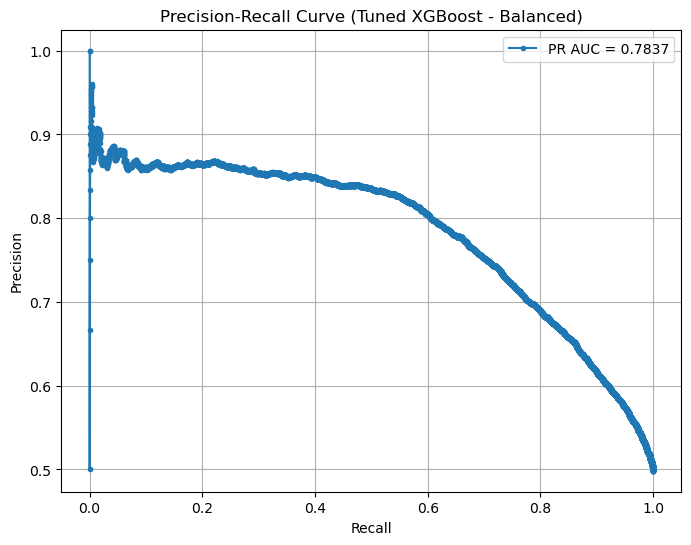

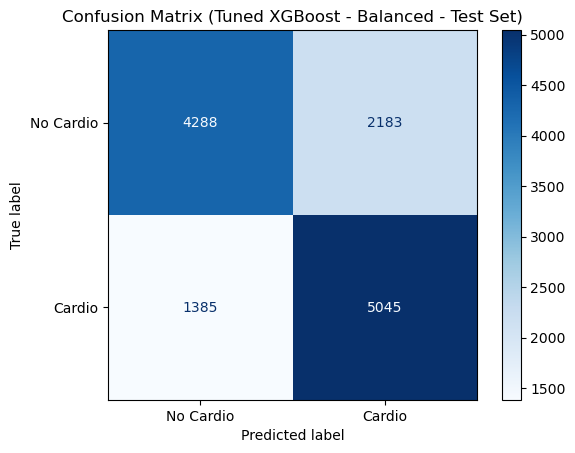

In [24]:
print(f"Best Model: Tuned XGBoost (Balanced)")
print(f"Testing Accuracy: {round(accuracy_score(y_test, y_test_pred_best), 4)}")
print(f"ROC-AUC Score: {round(roc_auc_score(y_test, y_test_prob_best), 4)}")
print(f"Precision-Recall AUC: {round(pr_auc, 4)}")
print(f"Recall (Class 1): {round(classification_report(y_test, y_test_pred_best, output_dict=True)['1']['recall'], 4)}")
print(f"Precision (Class 1): {round(classification_report(y_test, y_test_pred_best, output_dict=True)['1']['precision'], 4)}")
print(f"F1-Score (Class 1): {round(classification_report(y_test, y_test_pred_best, output_dict=True)['1']['f1-score'], 4)}")
print("\nConfusion Matrix (Best Model - Test Set):")
print(cm_best)

# Visualize Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'PR AUC = {round(pr_auc, 4)}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Tuned XGBoost - Balanced)')
plt.legend()
plt.grid()
plt.show()

# Visualize Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=['No Cardio', 'Cardio'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Tuned XGBoost - Balanced - Test Set)')
plt.show()

In [25]:
# Save evaluation results
evaluation_results = {
    'Model': 'Tuned XGBoost (Balanced)',
    'Accuracy': round(accuracy_score(y_test, y_test_pred_best), 4),
    'ROC-AUC': round(roc_auc_score(y_test, y_test_prob_best), 4),
    'PR-AUC': round(pr_auc, 4),
    'Recall (Class 1)': round(classification_report(y_test, y_test_pred_best, output_dict=True)['1']['recall'], 4),
    'Precision (Class 1)': round(classification_report(y_test, y_test_pred_best, output_dict=True)['1']['precision'], 4),
    'F1-Score (Class 1)': round(classification_report(y_test, y_test_pred_best, output_dict=True)['1']['f1-score'], 4),
    'Confusion Matrix': cm_best.tolist()
}
joblib.dump(evaluation_results, "C:\\Users\\Faizan\\OneDrive - BENNETT UNIVERSITY\\blood disease\\cardio_train.csv\\evaluation_results_Tuned_XGBoost_balanced.pkl")
print(f"\nEvaluation results saved as: C:\\Users\\Faizan\\OneDrive - BENNETT UNIVERSITY\\blood disease\\cardio_train.csv\\evaluation_results_Tuned_XGBoost_balanced.pkl")


Evaluation results saved as: C:\Users\Faizan\OneDrive - BENNETT UNIVERSITY\blood disease\cardio_train.csv\evaluation_results_Tuned_XGBoost_balanced.pkl


In [26]:
# Deployment Script
def predict_cardio(patient_data):
    # Feature engineering for new data
    df = pd.DataFrame([patient_data])
    df['bp_category'] = pd.cut(df['ap_hi'], bins=[0, 120, 130, 140, float('inf')], 
                              labels=['Normal', 'Elevated', 'High Stage 1', 'High Stage 2'])
    df['bp_interaction'] = df['ap_hi'] * df['ap_lo']
    df = pd.get_dummies(df, columns=['bp_category'], drop_first=True)
    df = df.reindex(columns=X.columns, fill_value=0)  # Align with training features
    scaler = StandardScaler()
    numerical_cols = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi', 'bp_interaction']
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    # Predict
    probability = best_model.predict_proba(df)[:, 1]
    prediction = (probability >= best_threshold).astype(int)[0]
    return 'Cardio' if prediction == 1 else 'No Cardio', probability[0]

In [27]:
# Example usage with input validation
sample_patient = {
    'age_years': 50,
    'height': 165,
    'weight': 70,
    'ap_hi': 140,
    'ap_lo': 90,
    'cholesterol': 2,
    'gluc': 1,
    'smoke': 0,
    'alco': 0,
    'active': 1,
    'bmi': 25.7,
    'bp_interaction': 12600  # ap_hi * ap_lo
}
required_keys = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmi', 'bp_interaction']
if not all(key in sample_patient for key in required_keys):
    print("Error: Missing required patient data fields.")
else:
    result, prob = predict_cardio(sample_patient)
    print(f"\nDeployment Test - Prediction: {result}, Probability of Cardio: {prob:.4f}")


Deployment Test - Prediction: No Cardio, Probability of Cardio: 0.4789


In [28]:
# Save deployment script as a function for reuse
with open("C:\\Users\\Faizan\\OneDrive - BENNETT UNIVERSITY\\blood disease\\predict_cardio.py", "w") as f:
    f.write("import joblib\n")
    f.write("import pandas as pd\n")
    f.write("from sklearn.preprocessing import StandardScaler\n\n")
    f.write(f"best_model = joblib.load('{best_model_path}')\n")
    f.write(f"best_threshold = {best_threshold}\n")
    f.write("X_columns = " + str(list(X.columns)) + "\n\n")
    f.write("def predict_cardio(patient_data):\n")
    f.write("    if not all(key in patient_data for key in ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmi', 'bp_interaction']):\n")
    f.write("        return 'Error: Missing required patient data fields.', 0.0\n")
    f.write("    df = pd.DataFrame([patient_data])\n")
    f.write("    df['bp_category'] = pd.cut(df['ap_hi'], bins=[0, 120, 130, 140, float('inf')], labels=['Normal', 'Elevated', 'High Stage 1', 'High Stage 2'])\n")
    f.write("    df['bp_interaction'] = df['ap_hi'] * df['ap_lo']\n")
    f.write("    df = pd.get_dummies(df, columns=['bp_category'], drop_first=True)\n")
    f.write("    df = df.reindex(columns=X_columns, fill_value=0)\n")
    f.write("    scaler = StandardScaler()\n")
    f.write("    numerical_cols = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi', 'bp_interaction']\n")
    f.write("    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])\n")
    f.write("    probability = best_model.predict_proba(df)[:, 1]\n")
    f.write("    prediction = (probability >= best_threshold).astype(int)[0]\n")
    f.write("    return 'Cardio' if prediction == 1 else 'No Cardio', probability[0]\n")
print("\nDeployment script saved as: C:\\Users\\Faizan\\OneDrive - BENNETT UNIVERSITY\\blood disease\\predict_cardio.py")


Deployment script saved as: C:\Users\Faizan\OneDrive - BENNETT UNIVERSITY\blood disease\predict_cardio.py
